# Combination of SAM and depth anything simply

In [2]:
# 0. install dependencies: PyTorch, Segment-anything, OpenCV, matplotlib, tqdm, pandas, Transformers(for Depth Anything)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python matplotlib tqdm pandas
!pip install transformers accelerate safetensors

# 1. mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. file path configuration
import os
base_dir = "/content/drive/MyDrive/Colab Notebooks/MR_Project/endovis2018_sub"
# endo_image_dir = f"{base_dir}/train/image"
val_image_dir = f"{base_dir}/val/image"
val_label_dir = f"{base_dir}/val/label"

output_mask_dir = "/content/drive/MyDrive/Colab Notebooks/MR_Project/generated_files/sam_masks"
test_image_dir = "/content/drive/MyDrive/Colab Notebooks/MR_Project/generated_files/test/image"
test_label_dir = "/content/drive/MyDrive/Colab Notebooks/MR_Project/generated_files/test/label"
test_mask_dir  = "/content/drive/MyDrive/Colab Notebooks/MR_Project/generated_files/test/sam_mask"
fused_output_dir = "/content/drive/MyDrive/Colab Notebooks/MR_Project/generated_files/fused_depth"

for d in [output_mask_dir, test_image_dir, test_label_dir, test_mask_dir, fused_output_dir]:
    os.makedirs(d, exist_ok=True)

Looking in indexes: https://download.pytorch.org/whl/cu121
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-98ogjxss
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-98ogjxss
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
Mounted at /content/drive


In [6]:
# 3. import libraries and SAM model
import torch, cv2, numpy as np, shutil, matplotlib.pyplot as plt, pandas as pd
from tqdm import tqdm
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/content/drive/MyDrive/Colab Notebooks/MR_Project/models/sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

Using device: cuda


In [7]:
# 4. Define SAM mask inference function
def generate_mask_with_sam(image_path, predictor, save_path=None, visualize=False):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)
    masks, scores, _ = predictor.predict(point_coords=None, point_labels=None, multimask_output=True)
    best_mask = masks[np.argmax(scores)]
    if save_path:
        cv2.imwrite(save_path, (best_mask*255).astype(np.uint8))
    if visualize:
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1); plt.imshow(image); plt.title("Original")
        plt.subplot(1,2,2); plt.imshow(best_mask,cmap='gray'); plt.title("Predicted Mask")
        plt.show(); plt.close('all')
    if device=="cuda": torch.cuda.empty_cache()
    return best_mask

In [8]:
# 5. Select validation samples
val_files = sorted([f for f in os.listdir(val_image_dir) if f.endswith(".bmp")])
if len(val_files)==0: raise ValueError(f"{val_image_dir} empty!")

np.random.seed(42)
num_samples = min(20,len(val_files))
sample_files = np.random.choice(val_files,num_samples,replace=False)
print("Selected validate files:",sample_files)

for fname in sample_files:
    shutil.copy(os.path.join(val_image_dir,fname),os.path.join(test_image_dir,fname))
    shutil.copy(os.path.join(val_label_dir,fname),os.path.join(test_label_dir,fname))
    generate_mask_with_sam(os.path.join(test_image_dir,fname),predictor,save_path=os.path.join(test_mask_dir,fname))

# 6. pixel-level accuracy calculation: SAM mask and the groundtruth
# Endovis 2018 dataset provides groundtruth
accuracy_list=[]
for fname in sample_files:
    label = cv2.imread(os.path.join(test_label_dir,fname),cv2.IMREAD_GRAYSCALE)
    mask  = cv2.imread(os.path.join(test_mask_dir,fname),cv2.IMREAD_GRAYSCALE)
    mask_bin = (mask>127).astype(np.uint8)
    label_bin = (label>127).astype(np.uint8)
    acc = (mask_bin==label_bin).sum()/label_bin.size
    accuracy_list.append({"filename":fname,"accuracy":acc})
accuracy_df = pd.DataFrame(accuracy_list)
accuracy_df["accuracy"] = (accuracy_df["accuracy"]*100).round(2)
print(f"Average pixel-level accuracy: {accuracy_df['accuracy'].mean():.2f}%")
display(accuracy_df)

Selected validate files: ['seq_5_frame286.bmp' 'seq_1_frame298.bmp' 'seq_5_frame299.bmp'
 'seq_3_frame230.bmp' 'seq_2_frame254.bmp' 'seq_6_frame244.bmp'
 'seq_6_frame227.bmp' 'seq_2_frame274.bmp' 'seq_1_frame293.bmp'
 'seq_7_frame225.bmp' 'seq_1_frame234.bmp' 'seq_3_frame269.bmp'
 'seq_6_frame256.bmp' 'seq_2_frame234.bmp' 'seq_5_frame296.bmp'
 'seq_6_frame238.bmp' 'seq_7_frame270.bmp' 'seq_1_frame255.bmp'
 'seq_5_frame241.bmp' 'seq_6_frame258.bmp']
Average pixel-level accuracy: 68.96%


,filename,accuracy
0,seq_5_frame286.bmp,60.63
1,seq_1_frame298.bmp,95.36
2,seq_5_frame299.bmp,7.77
3,seq_3_frame230.bmp,51.25
4,seq_2_frame254.bmp,55.97
5,seq_6_frame244.bmp,100.00
6,seq_6_frame227.bmp,85.56
7,seq_2_frame274.bmp,71.44
8,seq_1_frame293.bmp,99.97
9,seq_7_frame225.bmp,56.54


In [9]:
# 7. Hugging Face Depth Anything pipeline
from transformers import pipeline
from PIL import Image

depth_pipe = pipeline(
    task="depth-estimation",
    model="depth-anything/Depth-Anything-V2-Small-hf",
    device=0 if torch.cuda.is_available() else -1
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [10]:
# 8. Define (optimized) mask fusion function for following depth estimation
def generate_depth_with_mask_optimized(image_path, mask_path,
                                       base_strength_org=0.5,   # strength factor for tissue, set as 0.5
                                       base_strength_tool=0.8,  # strength factor for tool, set as 0.8
                                       blur_ksize=7,            # Kernel size of Gaussian blur, for noise suppression, odd number
                                       depth_pipe=None):
    img = np.array(Image.open(image_path).convert("RGB")).astype(np.float32)
    mask = np.array(Image.open(mask_path).convert("L"))
    mask_bin = (mask>127).astype(np.float32)
    mask_smooth = cv2.GaussianBlur(mask_bin,(blur_ksize,blur_ksize),0) # mask_smooth: smooth version of SAM Mask, the bigger blur_ksize, the smooth the edge

    red_ch = img[...,0] # pick up the Red channel of image, roughly determine the mask is tissue or Tool
    tissue_mask = (mask_smooth>0)&(red_ch>100)
    tool_mask   = (mask_smooth>0)&(red_ch<=100)

    out = img.copy()
    # human tissue: enhance G/B channels (due to red/pink color); R-0 G-1 B-2
    out[tissue_mask,1] = out[tissue_mask,1]*(1-base_strength_org)+255*base_strength_org
    out[tissue_mask,2] = out[tissue_mask,2]*(1-base_strength_org)+255*base_strength_org
    # tool: enhance B channel, and reduce R channel (due to the silver/gray/black color)
    out[tool_mask,2] = out[tool_mask,2]*(1-base_strength_tool)+255*base_strength_tool
    out[tool_mask,0] = out[tool_mask,0]*(1-0.3*base_strength_tool)

    mod_img = np.clip(out,0,255).astype(np.uint8)

    if depth_pipe is not None:
        input_img = Image.fromarray(mod_img)
        result = depth_pipe(input_img)
        depth = np.array(result["depth"])
        depth_norm = (depth-depth.min())/(depth.max()-depth.min()+1e-8)
        depth_uint8 = (depth_norm*255).astype(np.uint8)
    else:
        depth_uint8=None

    return mod_img, depth_uint8

In [11]:
# 9. Batch generate depth maps and visualize comparisons
output_dir = "/content/drive/MyDrive/Colab Notebooks/MR_Project/generated_files/depth_optimized"
os.makedirs(output_dir,exist_ok=True)

comparison_dir = os.path.join(output_dir,"visual_comparison")
os.makedirs(comparison_dir,exist_ok=True)

stats=[]
for fname in tqdm(sample_files,desc="Generating optimized depth"):
    img_path = os.path.join(test_image_dir,fname)
    mask_path = os.path.join(test_mask_dir,fname)

    # original depth
    result = depth_pipe(Image.open(img_path).convert("RGB"))
    depth = np.array(result["depth"])
    depth_norm = (depth-depth.min())/(depth.max()-depth.min()+1e-8)
    depth_uint8 = (depth_norm*255).astype(np.uint8)
    cv2.imwrite(os.path.join(output_dir,f"{fname}_original.png"),depth_uint8)
    stats.append({"file":fname,"mode":"original","mean_depth":depth_uint8.mean(),"std_depth":depth_uint8.std()})

    # optimized mask depth
    mod_img, depth_opt = generate_depth_with_mask_optimized(img_path,mask_path,depth_pipe=depth_pipe)
    cv2.imwrite(os.path.join(output_dir,f"{fname}_optimized.png"),depth_opt)
    stats.append({"file":fname,"mode":"optimized","mean_depth":depth_opt.mean(),"std_depth":depth_opt.std()})

    # comparison
    img_rgb = np.array(Image.open(img_path).convert("RGB"))
    mask_arr = np.array(Image.open(mask_path).convert("L"))
    fig, axes = plt.subplots(1,4,figsize=(18,4))
    axes[0].imshow(img_rgb); axes[0].set_title("Original"); axes[0].axis("off")
    axes[1].imshow(mask_arr,cmap="gray"); axes[1].set_title("SAM Mask"); axes[1].axis("off")
    axes[2].imshow(depth_uint8,cmap="plasma"); axes[2].set_title("Depth: Original"); axes[2].axis("off")
    axes[3].imshow(depth_opt,cmap="plasma"); axes[3].set_title("Depth: Optimized"); axes[3].axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(comparison_dir,fname.replace(".bmp","_compare.png")))
    plt.close(fig)

# Save data...
stats_df = pd.DataFrame(stats)
stats_csv = os.path.join(output_dir,"depth_statistics.csv")
stats_df.to_csv(stats_csv,index=False)
display(stats_df.head())

Generating optimized depth: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


,file,mode,mean_depth,std_depth
0,seq_5_frame286.bmp,original,93.475597,63.258474
1,seq_5_frame286.bmp,optimized,86.098820,65.405257
2,seq_1_frame298.bmp,original,62.129711,57.889218
3,seq_1_frame298.bmp,optimized,62.244400,66.127024
4,seq_5_frame299.bmp,original,119.359894,60.746221


total 20 comparisons。
seq_1_frame234_compare.png


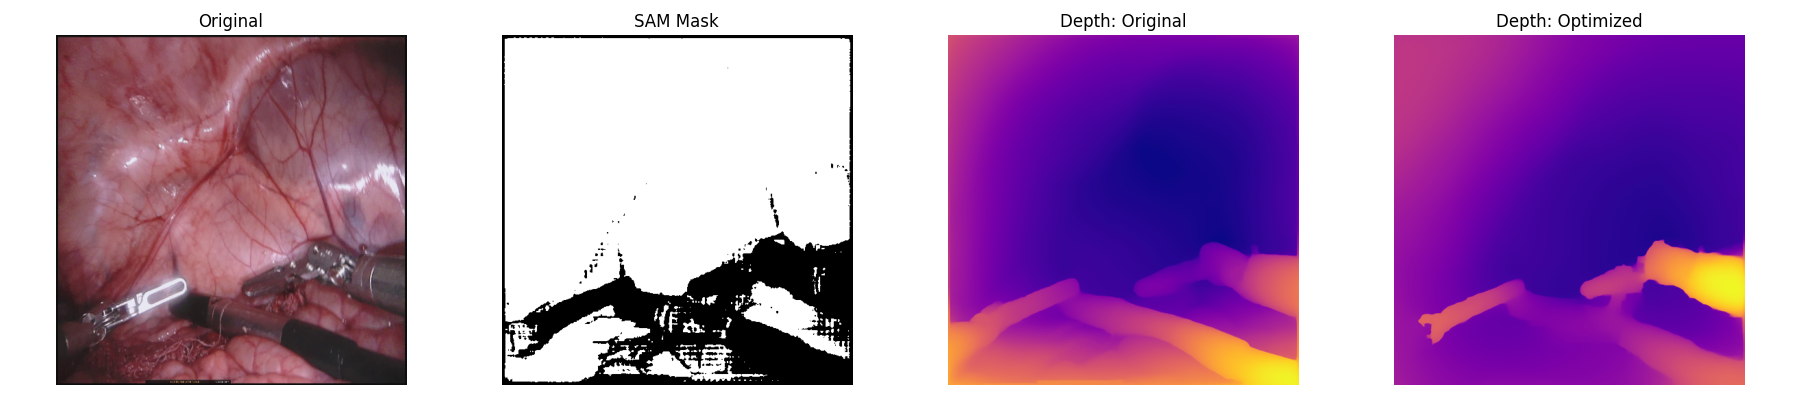

seq_1_frame255_compare.png


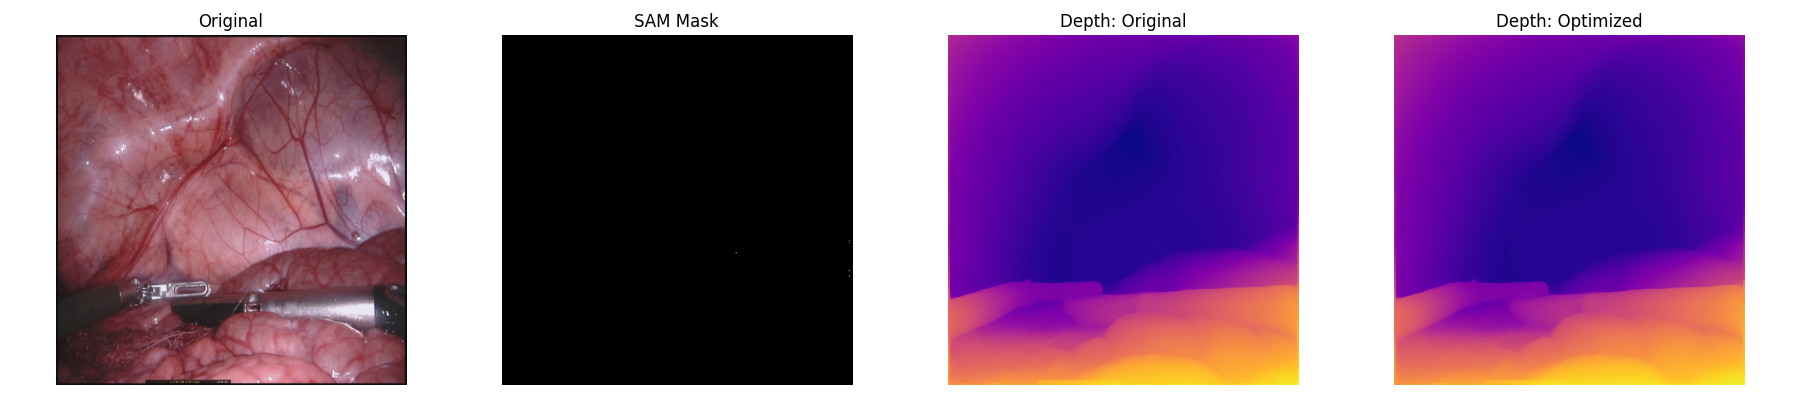

seq_1_frame293_compare.png


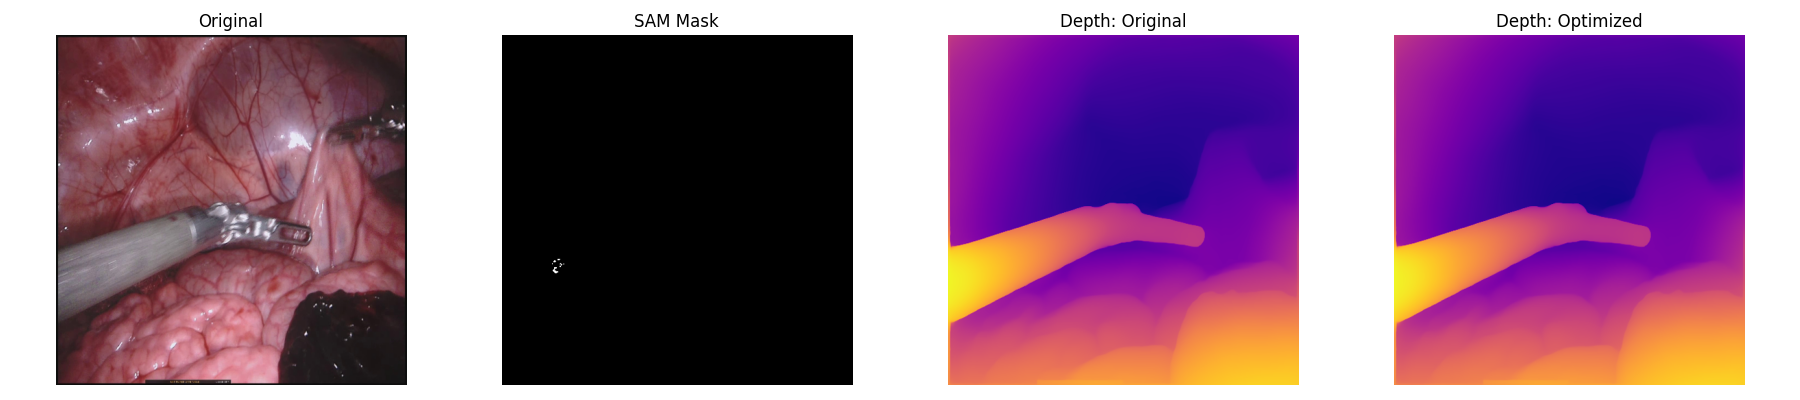

seq_1_frame298_compare.png


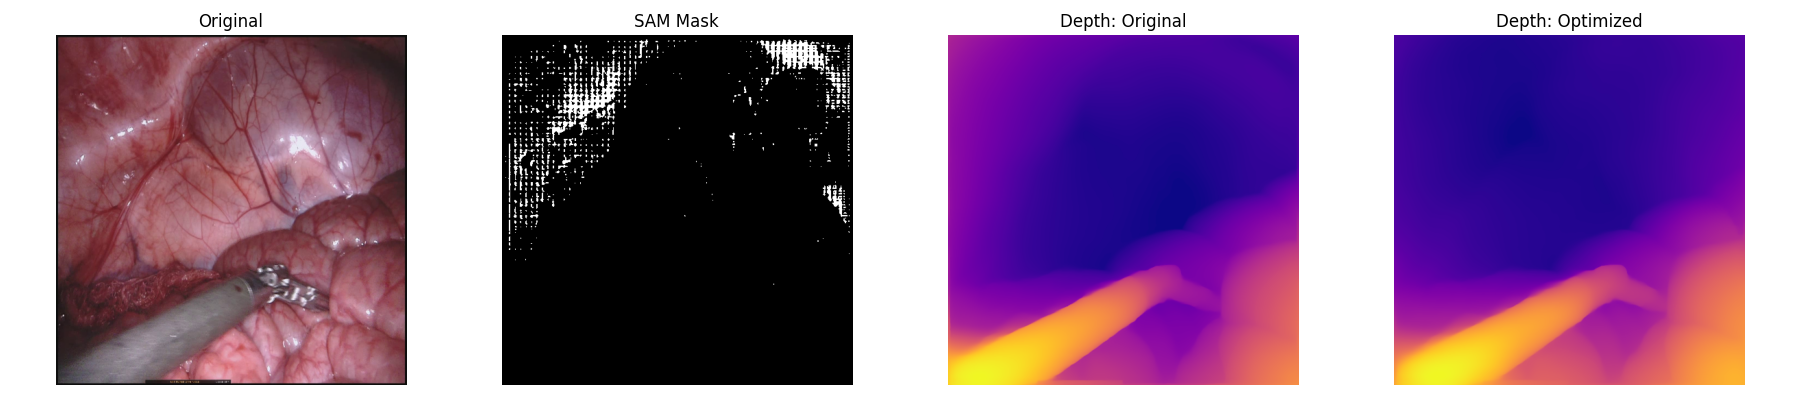

seq_2_frame234_compare.png


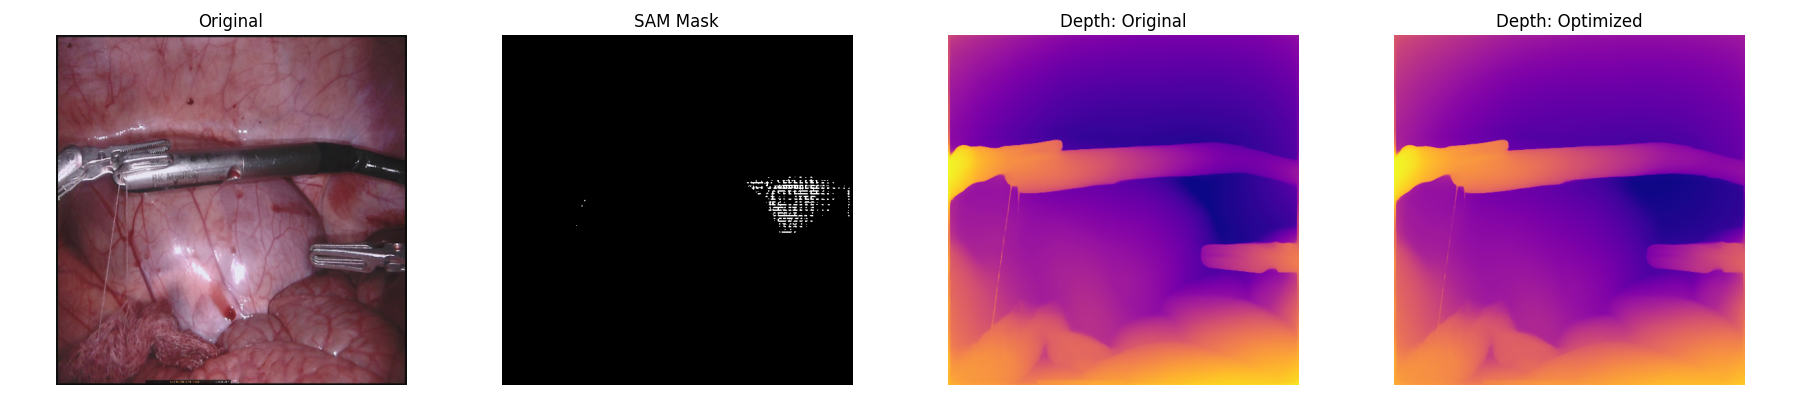

seq_2_frame254_compare.png


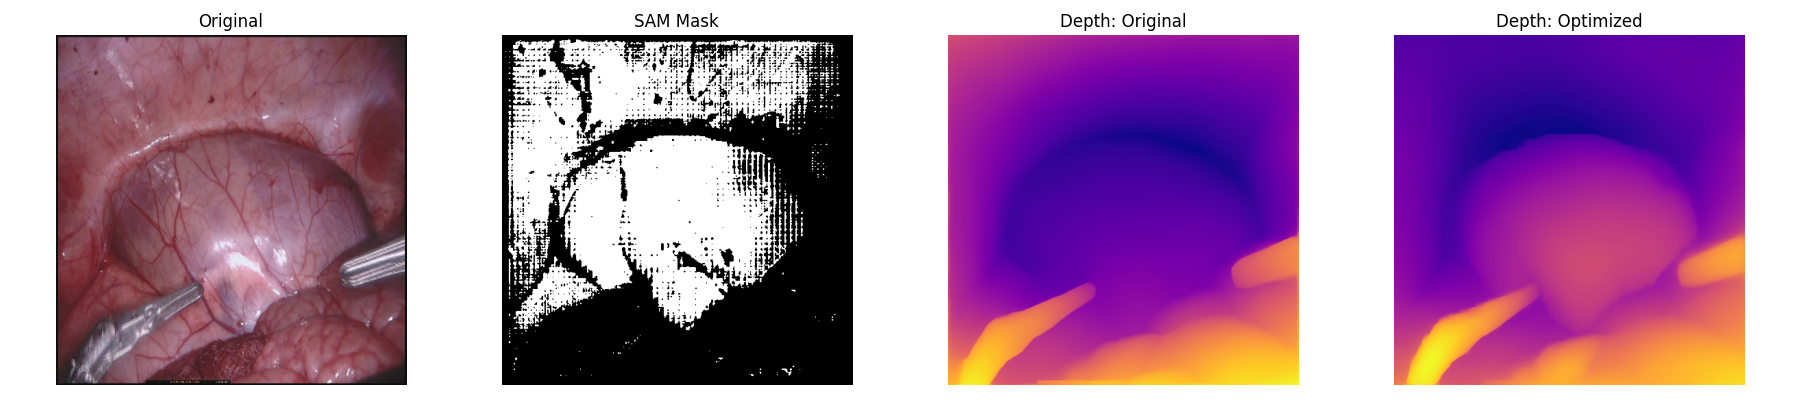

In [12]:
# Visualize some images

import glob
from IPython.display import Image as IPImage, display as ipy_display

comparison_images = sorted(glob.glob(os.path.join(comparison_dir,"*_compare.png")))
print(f"total {len(comparison_images)} comparisons。")
for path in comparison_images[:6]:
    print(os.path.basename(path))
    ipy_display(IPImage(filename=path))

In [14]:
!jupyter nbextension disable --py widgetsnbextension

Disabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
